In [1]:
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import json
import re

In [2]:
!for model in *.tflite; do zip $model.zip $model; done
!ls -la | grep -E "(.tflite|.zip)$"

updating: cnn_not_optimised-default_opt.tflite (deflated 28%)
updating: cnn_not_optimised-int8_quant.tflite (deflated 27%)
updating: cnn_not_optimised-no_opt.tflite (deflated 10%)
updating: cnn_pruned-default_opt.tflite (deflated 62%)
updating: cnn_pruned-int8_quant.tflite (deflated 62%)
updating: cnn_pruned-no_opt.tflite (deflated 68%)
-rw-r--r-- 1 dhdhxji dhdhxji   21360 Feb 13 22:01 cnn_not_optimised-default_opt.tflite
-rw-r--r-- 1 dhdhxji dhdhxji   15602 Apr  9 19:50 cnn_not_optimised-default_opt.tflite.zip
-rw-r--r-- 1 dhdhxji dhdhxji   21016 Feb 13 22:02 cnn_not_optimised-int8_quant.tflite
-rw-r--r-- 1 dhdhxji dhdhxji   15464 Apr  9 19:50 cnn_not_optimised-int8_quant.tflite.zip
-rw-r--r-- 1 dhdhxji dhdhxji   59576 Feb 13 22:01 cnn_not_optimised-no_opt.tflite
-rw-r--r-- 1 dhdhxji dhdhxji   54112 Apr  9 19:50 cnn_not_optimised-no_opt.tflite.zip
-rw-r--r-- 1 dhdhxji dhdhxji   21360 Feb 13 22:02 cnn_pruned-default_opt.tflite
-rw-r--r-- 1 dhdhxji dhdhxji    8359 Apr  9 19:50 cnn_prune

In [3]:
models = sorted(glob('*.tflite'))
models_compressed = sorted(glob('*.tflite.zip'))

models, models_compressed

(['cnn_not_optimised-default_opt.tflite',
  'cnn_not_optimised-int8_quant.tflite',
  'cnn_not_optimised-no_opt.tflite',
  'cnn_pruned-default_opt.tflite',
  'cnn_pruned-int8_quant.tflite',
  'cnn_pruned-no_opt.tflite'],
 ['cnn_not_optimised-default_opt.tflite.zip',
  'cnn_not_optimised-int8_quant.tflite.zip',
  'cnn_not_optimised-no_opt.tflite.zip',
  'cnn_pruned-default_opt.tflite.zip',
  'cnn_pruned-int8_quant.tflite.zip',
  'cnn_pruned-no_opt.tflite.zip'])

In [4]:
def get_sizes(paths):
    return [os.path.getsize(path) for path in paths]

get_sizes(models), get_sizes(models_compressed)

([21360, 21016, 59576, 21360, 21016, 59576],
 [15602, 15464, 54112, 8359, 8229, 19347])

In [5]:
with open('models_stats.json') as f:
    precision = json.load(f)

precision

{'cnn_not_optimised-no_opt.tflite': 0.8971650276582668,
 'cnn_not_optimised-default_opt.tflite': 0.8954363859864782,
 'cnn_not_optimised-int8_quant.tflite': 0.8700061462814997,
 'cnn_pruned-no_opt.tflite': 0.8759219422249539,
 'cnn_pruned-default_opt.tflite': 0.8756146281499693,
 'cnn_pruned-int8_quant.tflite': 0.85029963122311}

In [6]:
model_inference_time = {}

def parse_model_bench_output(output):
    result = output.split('==============Summary of All Runs w/ Different Performance Options==============\n')[1].splitlines()
    result = [line.strip('INFO: ') for line in result]
    result = {line.split(':')[0]: line.split(':')[1].strip().split() for line in result}
    result = {key : {value.split('=')[0]: float(value.split('=')[1]) for value in tuple_value}
                    for key, tuple_value in result.items()}
    return result


# ALSO! Include model size here!
for model_log in glob('power_data/*.log'):
    print(f'Processing {model_log}...') 
    model_name = model_log.replace('.log', '')
    with open(model_log) as f:
        model_path = model_name.replace('_tflite', '.tflite').replace('power_data/', '')
        model_path = re.sub(r'^(.*)(_)(.*_.*)$', r'\1-\3', model_path)
        # model_path = m.group(1)
        model_inference_time[model_path] = parse_model_bench_output(f.read())['single core cpu']['avg']

model_inference_time

Processing power_data/cnn_pruned_no_opt_tflite.log...
Processing power_data/cnn_pruned_default_opt_tflite.log...
Processing power_data/cnn_pruned_int8_quant_tflite.log...
Processing power_data/cnn_not_optimised_int8_quant_tflite.log...
Processing power_data/cnn_not_optimised_default_opt_tflite.log...
Processing power_data/cnn_not_optimised_no_opt_tflite.log...


{'cnn_pruned-no_opt.tflite': 90160.8,
 'cnn_pruned-default_opt.tflite': 64078.4,
 'cnn_pruned-int8_quant.tflite': 62869.4,
 'cnn_not_optimised-int8_quant.tflite': 62879.1,
 'cnn_not_optimised-default_opt.tflite': 64079.2,
 'cnn_not_optimised-no_opt.tflite': 90172.6}

In [7]:
power_consumption = {
  'cnn_not_optimised-default_opt.tflite': 1237,
  'cnn_not_optimised-int8_quant.tflite': 1384,
  'cnn_not_optimised-no_opt.tflite': 1946,
  'cnn_pruned-default_opt.tflite': 1468,
  'cnn_pruned-int8_quant.tflite': 1384,
  'cnn_pruned-no_opt.tflite': 1769
}

In [8]:
model_human_readable_names = {
    'cnn_not_optimised-default_opt.tflite': '32-bit interger quantization',
    'cnn_not_optimised-int8_quant.tflite': '8-bit interger quantization',
    'cnn_not_optimised-no_opt.tflite': 'Baseline (not optimized)',
    'cnn_pruned-default_opt.tflite': 'Pruning + 32-bit interger quantization',
    'cnn_pruned-int8_quant.tflite': 'Pruning + 8-bit interger quantization',
    'cnn_pruned-no_opt.tflite': 'Pruning'
}

In [9]:
results = df()
results['filename'] = models
results['filename_compressed'] = models_compressed
results['desc'] = results['filename'].map(model_human_readable_names)
results['model_size'] = get_sizes(models)
results['compressed_model_size'] = get_sizes(models_compressed)
results['precision'] = results['filename'].map(precision)
results['inference_time'] = results['filename'].map(model_inference_time)
results['power_consumption'] = results['filename'].map(power_consumption)

results_percents = results.copy()
for col in ('model_size', 'compressed_model_size', 'precision', 'inference_time', 'power_consumption'):
    results_percents[col] = results_percents[col] / np.max(results_percents[col]) * 100

results_percents

,filename,filename_compressed,desc,model_size,compressed_model_size,precision,inference_time,power_consumption
0,cnn_not_optimised-default_opt.tflite,cnn_not_optimised-default_opt.tflite.zip,32-bit interger quantization,35.853364,28.832791,99.807322,71.062828,63.566290
1,cnn_not_optimised-int8_quant.tflite,cnn_not_optimised-int8_quant.tflite.zip,8-bit interger quantization,35.275950,28.577765,96.972811,69.731936,71.120247
2,cnn_not_optimised-no_opt.tflite,cnn_not_optimised-no_opt.tflite.zip,Baseline (not optimized),100.000000,100.000000,100.000000,100.000000,100.000000
3,cnn_pruned-default_opt.tflite,cnn_pruned-default_opt.tflite.zip,Pruning + 32-bit interger quantization,35.853364,15.447590,97.597945,71.061941,75.436793
4,cnn_pruned-int8_quant.tflite,cnn_pruned-int8_quant.tflite.zip,Pruning + 8-bit interger quantization,35.275950,15.207348,94.776279,69.721179,71.120247
5,cnn_pruned-no_opt.tflite,cnn_pruned-no_opt.tflite.zip,Pruning,100.000000,35.753622,97.632199,99.986914,90.904419


In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def get_hist_data(frame, key, val):
    return frame[frame[key] == val]

get_hist_data(results_percents, 'filename', 'cnn_not_optimised-default_opt.tflite')

,filename,filename_compressed,desc,model_size,compressed_model_size,precision,inference_time,power_consumption
0,cnn_not_optimised-default_opt.tflite,cnn_not_optimised-default_opt.tflite.zip,32-bit interger quantization,35.853364,28.832791,99.807322,71.062828,63.56629


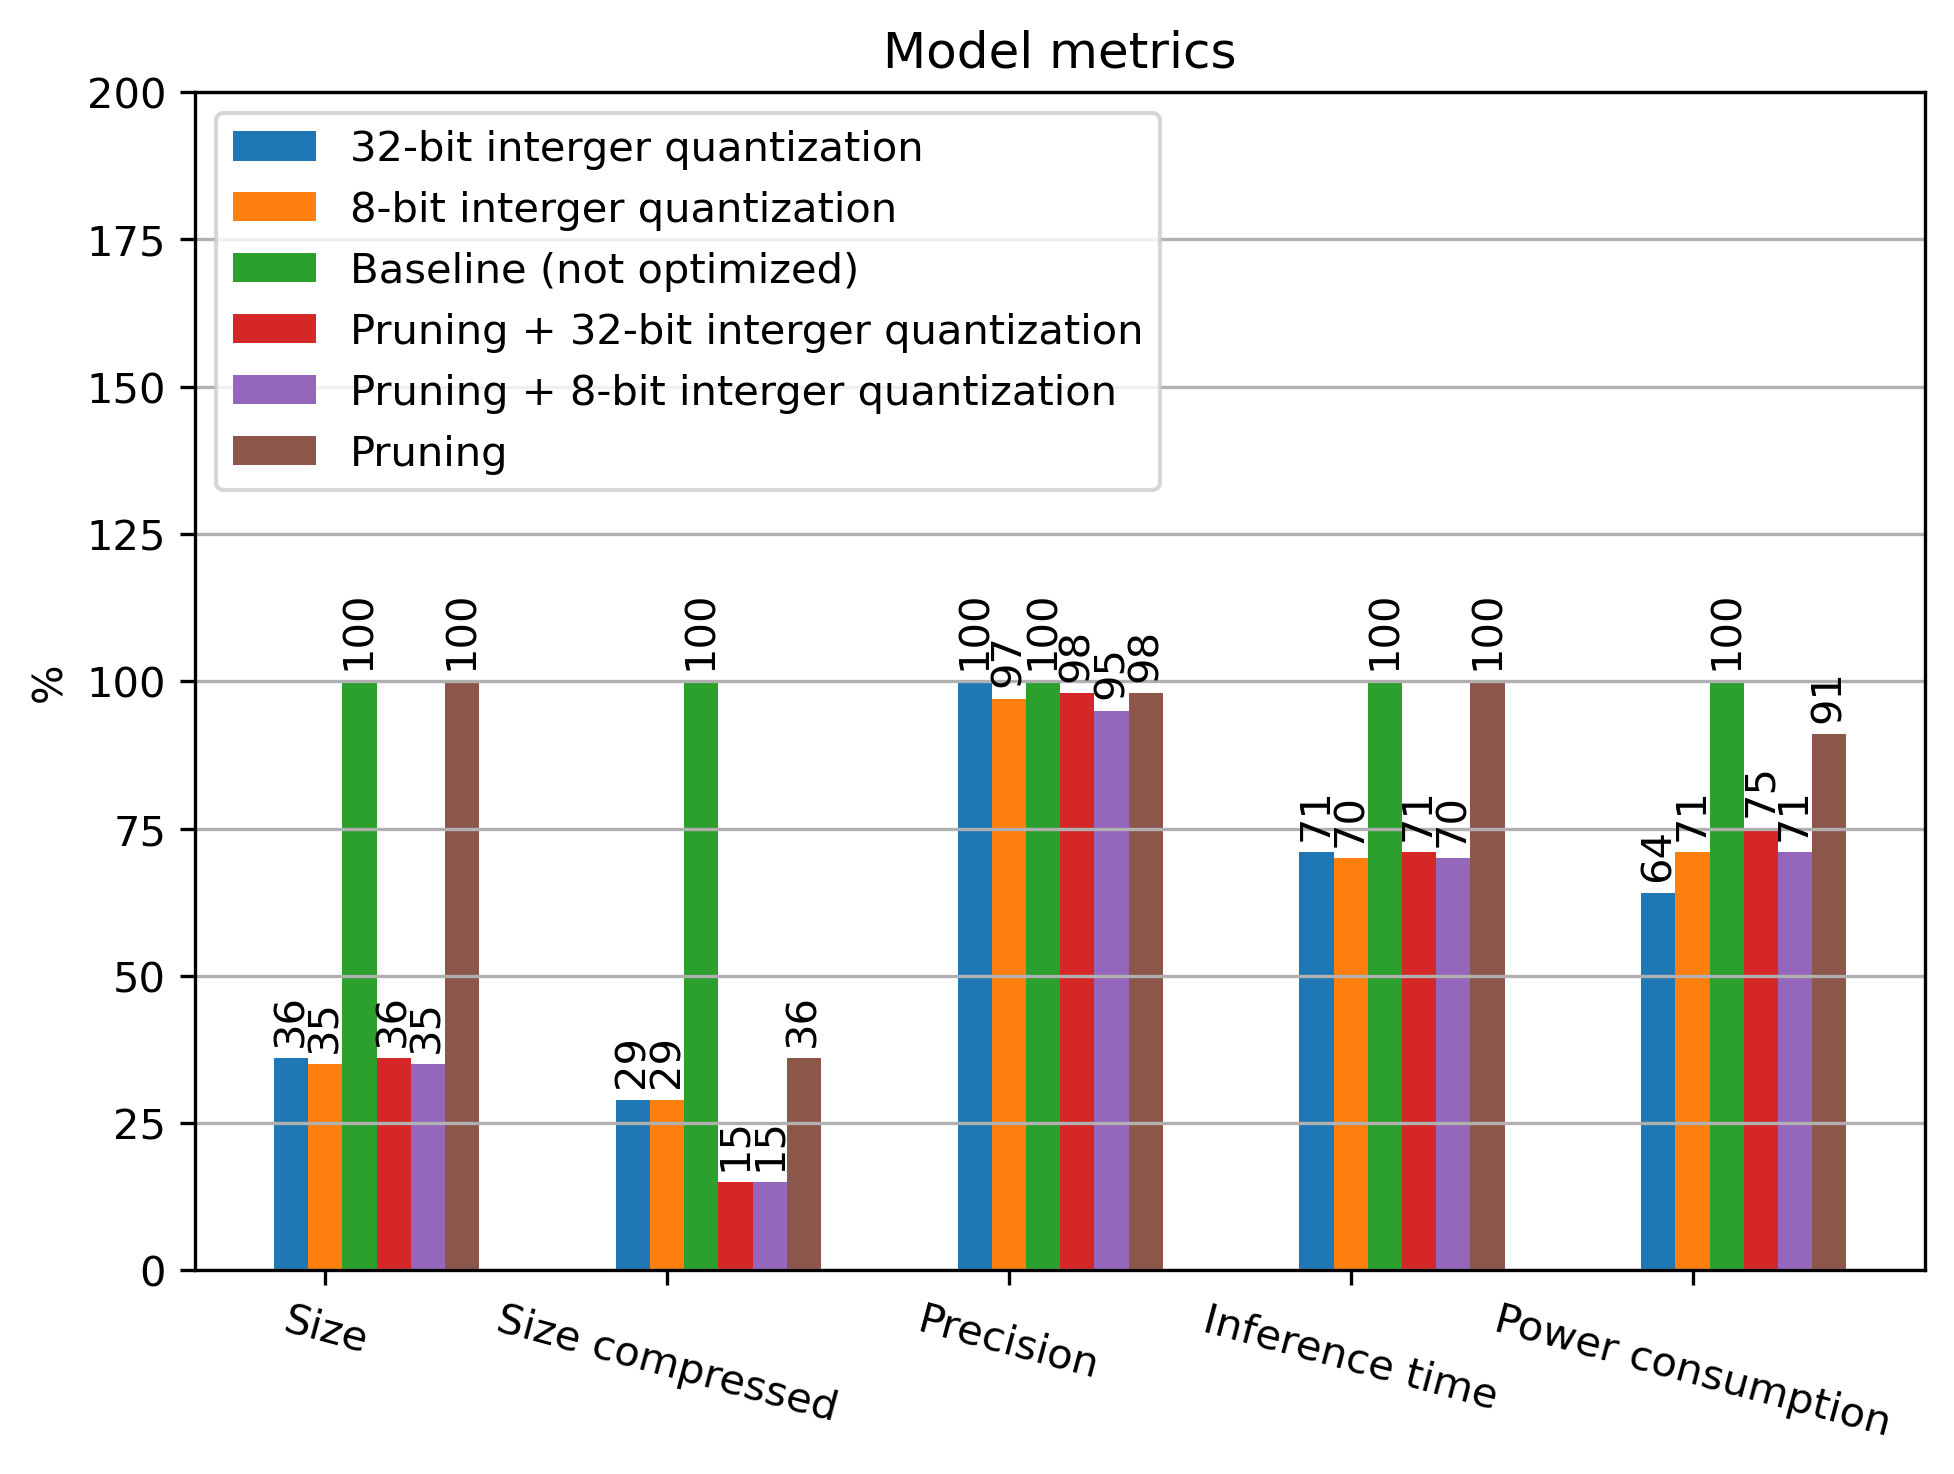

In [11]:
# species = ("Adelie", "Chinstrap", "Gentoo")
metrics = list(results_percents.keys()[3:])
metrics_human_readable = {
    'model_size': 'Size',
    'compressed_model_size': 'Size compressed',
    'precision': 'Precision',
    'inference_time': 'Inference time',
    'power_consumption': 'Power consumption'
}

# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }
model_params = {row['desc']: np.round(tuple(row[metrics])) for _, row in results_percents.iterrows()}

x = np.arange(len(metrics))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_params.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('Model metrics')
ax.set_xticks(x + width, map(lambda x: metrics_human_readable[x], metrics), rotation=-15)
ax.legend(loc='upper left')
ax.set_ylim(0, 200)
ax.grid(axis='y')

plt.show()